<a href="https://colab.research.google.com/github/YUFULEO/End-to-End-Pipeline-to-classify-News-Articles/blob/main/ECE219_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import re
import random
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
import itertools
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import umap
import umap.plot
import warnings

warnings.filterwarnings("ignore")
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
np.random.seed(42)
random.seed(42)


/Users/scott/anaconda3/envs/cs2191/lib/python3.10/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/scott/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/scott/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/scott/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/scott/nltk_data...
[nltk_data]   Packag

In [ ]:
# Read Data
df = pd.read_csv('Project1-ClassificationDataset.csv')

In [ ]:
# Get number of rows and columns
rows, cols = df.shape
print("Number of rows: ", rows)
print("Number of columns: ", cols)

Number of rows:  3476
Number of columns:  8


### <span style="color:lightpink">Question 1:</span>

**- How many rows (samples) and columns (features) are present in the dataset?**

There are 3476 rows and 8 columns in the dataset.

**- Histograms:**

See the plot histograms below.

**- Interpret Plots:**

We find that the data is distributed evenly across the different classes. The data is not skewed towards any particular class. The data is not imbalanced. So we can apply any classification algorithm on this dataset.

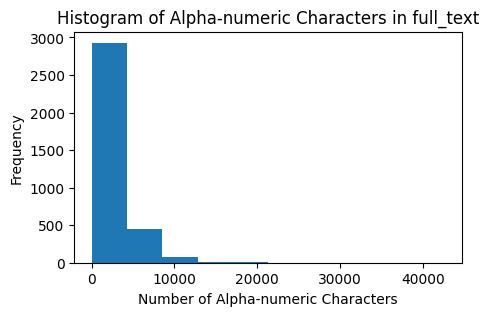

In [ ]:
# (a) Histogram for the total number of alpha-numeric characters per data point in the 'full_text' column
df['char_count'] = df['full_text'].apply(lambda x: len([char for char in str(x) if char.isalnum()]))
plt.figure(figsize=(5, 3))
plt.hist(df['char_count'])
plt.title('Histogram of Alpha-numeric Characters in full_text')
plt.xlabel('Number of Alpha-numeric Characters')
plt.ylabel('Frequency')
plt.show()

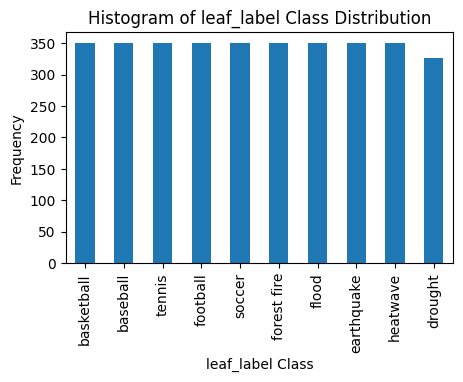

In [ ]:
# (b) Histogram for the 'leaf_label' class occurrences
plt.figure(figsize=(5, 3))
df['leaf_label'].value_counts().plot(kind='bar')
plt.title('Histogram of leaf_label Class Distribution')
plt.xlabel('leaf_label Class')
plt.ylabel('Frequency')
plt.show()


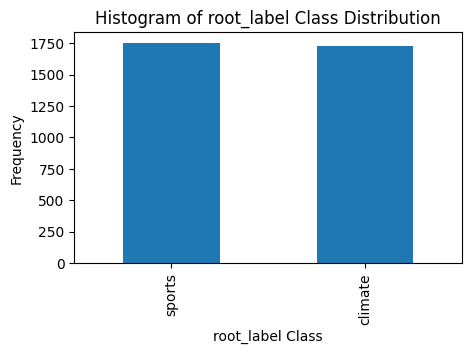

In [ ]:
# (c) Histogram for the 'root_label' class occurrences
plt.figure(figsize=(5, 3))
df['root_label'].value_counts().plot(kind='bar')
plt.title('Histogram of root_label Class Distribution')
plt.xlabel('root_label Class')
plt.ylabel('Frequency')
plt.show()

# Binary Classification

## 1. Splitting the entire dataset into training and testing data

In [ ]:
train, test = train_test_split(df[["full_text","root_label"]], test_size=0.2, random_state=42)

In [ ]:
# QUESTION 2: Report the number of training and testing samples.
print("Number of training samples: ", len(train))
print("Number of testing samples: ", len(test))

Number of training samples:  2780
Number of testing samples:  696


### <span style="color:lightpink">QUESTION 2: </span>

**- Report the number of training and testing samples.**

There are 2780 training samples and 696 testing samples.

## 2. Feature Extraction

In [ ]:
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

In [ ]:
def convert_to_wordnet_tag(nltk_tag):
    # initialize the variables
    adj = wordnet.ADJ
    verb = wordnet.VERB
    adv = wordnet.ADV
    n = wordnet.NOUN

    # convert the nltk tag to wordnet tag
    if nltk_tag.startswith('J'):
        return adj
    elif nltk_tag.startswith('V'):
        return verb
    elif nltk_tag.startswith('R'):
        return adv
    elif nltk_tag.startswith('N'):
        return n
    else:
        return None

Wordnet_Lemmatizer = WordNetLemmatizer()

# function to lemmatize the text
def lemmatize_text(text):
    # tokenize words from text
    tokens_from_text = nltk.word_tokenize(text)
    # find pos tag for tokens
    tagged_tokens = pos_tag(tokens_from_text)

    already_lemmatized_text = []

    # loop function to check each tag
    for tag in tagged_tokens:
       # ignore any numbers in the text
       if tag[0].isalpha():
            wordnet_get = convert_to_wordnet_tag(tag[1]) or wordnet.NOUN
            already_lemmatized_text.append(Wordnet_Lemmatizer.lemmatize(tag[0], pos = wordnet_get))

    special_character = " "

    return special_character.join(already_lemmatized_text)

In [ ]:
# Apply the clean function to the training and testing data
train['full_text'] = train['full_text'].apply(clean)
test['full_text'] = test['full_text'].apply(clean)

# Apply the lemmatize function to the training and testing data
train['full_text'] = train['full_text'].apply(lemmatize_text)
test['full_text'] = test['full_text'].apply(lemmatize_text)


In [ ]:
count_vect = CountVectorizer(stop_words='english', min_df=3)
X_train_counts = count_vect.fit_transform(train['full_text'])
X_test_counts = count_vect.transform(test['full_text'])

In [ ]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts).toarray()
X_test_tfidf = tfidf_transformer.transform(X_test_counts).toarray()

In [ ]:
# report the shape of tf-idf matrix
print("Shape of tf-idf matrix: ", X_train_tfidf.shape)
print("Shape of tf-idf matrix: ", X_test_tfidf.shape)


Shape of tf-idf matrix:  (2780, 13620)
Shape of tf-idf matrix:  (696, 13620)


### <span style="color:lightpink">Question 3:</span>

**- What are the pros and cons of lemmatization versus stemming? How do these processes affect the dictionary size?**

There are some pros and cons of lemmatization versus stemming. For the pros, the first is high accuracy. Because it takes into account the complete morphological analysis of words, the results are more accurate and meaningful, especially for morphologically complex languages. The second one is having contextual awareness. Morphological reduction uses contextual and lexical tags to determine the base form of a word, ensuring that the root word is a valid word. This is something that stemming does not have. But the pros are higher computational cost and over-reliance on lexical tags. These processes also affect the size of the dictionary. Whether it is lemmatization or stemming, they both reduce the size of the dictionary. But their accuracy is different.

**- min_df means minimum document frequency. How does varying min_df change the TF-IDF matrix?**

First, it filters out rare words. If the parameter min_df is high, it means that words need to appear in more documents, which filters out rare words. The size of the vocabulary is reduced and the TF-IDF matrix is more focused on common words. In addition, it reduces noise and dimensionality. By increasing the value of min_df, the noise in the TF-IDF matrix can be reduced and the number of features in the matrix can be reduced to reduce noise and dimensionality. Finally, as the value of min_df increases, the TF-IDF may lose some details, which may lead to the omission of important words that are infrequent but relevant to the context.

**- Should I remove stopwords before or after lemmatizing? Should I remove punctuations before or after lemmatizing? Should I remove numbers before or after lemmatizing? Hint: Recall that the full sentence is input into the Lemmatizer and the lemmatizer is tagging the position of every word based on the sentence structure**

First, stopwords should be removed after lemmatizing, because removing them before may change the structure of the sentence. But lemmatizers mark words based on sentence structure and context, which may lead to lexical inaccuracies. In addition, punctuations should be removed before lemmatizing because removing punctuations will not change the structure of the sentence and will not affect lemmatizing. Finally, numbers should be removed before lemmatizing. Because lemmatizing itself removes all numbers, and remove numbers before lemmatizing will not have any effect.

**- Report the shape of the TF-IDF-processed train and test matrices. The number of rows should match the results of Question 2. The number of columns should roughly be in the order of k×10^3. This dimension will vary depending on your exact method of cleaning and lemmatizing and that is okay.**

Shape of tf-idf train matrix:  (2780, 13620)

Shape of tf-idf test matrix:  (696, 13620)

## 3. Dimensionality Reduction

In [ ]:
# LSI on TF-IDF
svd = TruncatedSVD(n_components=50, n_iter = 10, random_state=42)
X_train_LSI = svd.fit_transform(X_train_tfidf)
X_test_LSI = svd.transform(X_test_tfidf)
print("Shape of LSI matrix: ", X_train_LSI.shape)

Shape of LSI matrix:  (2780, 50)


In [ ]:
# NMF on TF-IDF
nmf = NMF(n_components=50, init='random', random_state=42)
X_train_NMF = nmf.fit_transform(X_train_tfidf)
X_test_NMF = nmf.transform(X_test_tfidf)
print("Shape of NMF matrix: ", X_train_NMF.shape)

Shape of NMF matrix:  (2780, 50)


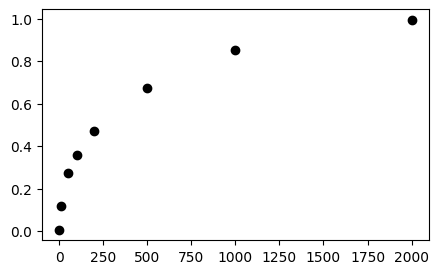

In [ ]:
k = [1, 10, 50, 100, 200, 500, 1000, 2000]
explained_variance_ratio = []

for i in range(len(k)):
    svd_t = TruncatedSVD(n_components=k[i], random_state=42)
    svd_t.fit(X_train_tfidf)
    explained_variance_ratio.append(sum(svd_t.explained_variance_ratio_))

plt.figure(figsize=(5, 3))
plt.plot(k, explained_variance_ratio, 'o', color='black')
plt.show()

In [ ]:
# MSE error for LSI
simga_lsi = svd.inverse_transform(X_train_LSI)
MSE_LSI = np.sum(np.square(X_train_tfidf - simga_lsi))

# MSE error for NMF
MSE_NMF = np.sum(np.square(X_train_tfidf - X_train_NMF.dot(nmf.components_)))

print("MSE error for LSI: ", MSE_LSI)
print("MSE error for NMF: ", MSE_NMF)

MSE error for LSI:  1960.1460070931482
MSE error for NMF:  1989.703137543792


### <span style="color:lightpink">Question 4:</span>

**Reduce the dimensionality of the data using the methods above:**

**- Plot the explained variance ratio across multiple different k = [1, 10, 50, 100, 200, 500, 1000, 2000] for LSI and for the next few sections choose k = 50. What does the explained variance ratio plot look like? What does the plot’s concavity suggest?**

The plot is shown above.

Since for LSI, early topic capture most general information, and later topics capture more specific and less informative.

The plot's concavity suggests that the explained variance ratio is increasing with the increase of k, but the rate of increase is decreasing. First, few components capture the most significant patterns in the data, while additional components capture increasingly subtle and less significant patterns.

**- With k = 50 found in the previous sections, calculate the reconstruction residual MSE error when using LSI and NMF – they both should use the same k = 50. Which one is larger and why?**

The NMF is larger. Because NMF is a non-negative matrix factorization, it is more suitable for data with non-negative values. But the TF-IDF matrix is a sparse matrix with many zero values. LSI can handle this situation better than NMF.So LSI is more suitable for this dataset.

## 4. Classification Algorithm

In [ ]:
# use the dimensionality-reduced training data from LSI
binary_training_label = []
binary_testing_label = []

def binary_label(root_label):
    if 'sports' in root_label:
        return 0
    else:
        return 1

binary_training_label = [binary_label(i) for i in train['root_label']]
binary_testing_label = [binary_label(i) for i in test['root_label']]

In [ ]:
def plot_and_metric(title, test, predict, multi_class=False):
    if multi_class:
        print(title)
        print('confusion_matrix:\n', confusion_matrix(test, predict))
        print('accuracy:', accuracy_score(test, predict))
        print('recall:', recall_score(test, predict, average='macro'))
        print('precision:', precision_score(test, predict, average='macro'))
        print('f1_score:', f1_score(test, predict, average='macro'))
    else:
        print(title)
        print('confusion_matrix:\n', confusion_matrix(test, predict))
        print('accuracy:', accuracy_score(test, predict))
        print('recall:', recall_score(test, predict))
        print('precision:', precision_score(test, predict))
        print('f1_score:', f1_score(test, predict))


def plot_roc_curve(estimator, x, y, name):
    plt.figure(figsize=(3, 2))
    roc = RocCurveDisplay.from_estimator(estimator, x, y, name=name)
    plt.title('ROC curve')

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize=(3, 2))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    # make y axis labels tilted
    plt.gca().set_xticklabels(classes, rotation = 45, ha="right")

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


#### Hard margin SVM

In [ ]:
# Train a Linear SVM classifier on the LSI training data
clf_SVM_hard = SVC(kernel='linear', C = 1000, random_state=42)
clf_SVM_hard.fit(X_train_LSI, binary_training_label)

# Predict the labels of the test data
predicted_SVM_hard = clf_SVM_hard.predict(X_test_LSI)
predicted_prob_SVM_hard = clf_SVM_hard.decision_function(X_test_LSI)


Hard Margin SVMs:
confusion_matrix:
 [[351  17]
 [ 12 316]]
accuracy: 0.9583333333333334
recall: 0.9634146341463414
precision: 0.948948948948949
f1_score: 0.9561270801815432


<Figure size 300x200 with 0 Axes>

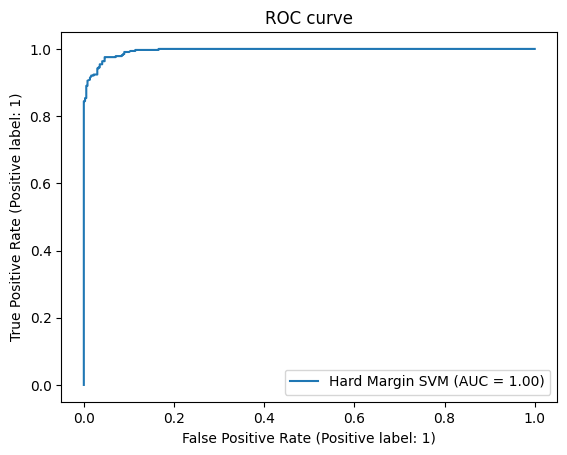

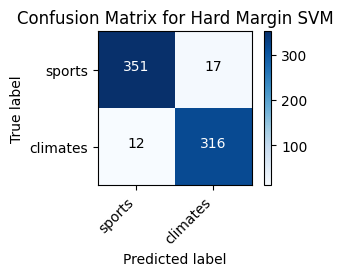

In [ ]:
class_names = ["sports", "climates"]

plot_and_metric('Hard Margin SVMs:', binary_testing_label, predicted_SVM_hard)
plot_roc_curve(clf_SVM_hard, X_test_LSI, binary_testing_label, 'Hard Margin SVM')
plot_confusion_matrix(confusion_matrix(binary_testing_label, predicted_SVM_hard), classes=class_names, title='Confusion Matrix for Hard Margin SVM')

#### Soft margin SVM

In [ ]:
# Train a Linear SVM classifier on the LSI training data
clf_SVM_soft = SVC(kernel='linear', C = 0.0001, random_state=42)
clf_SVM_soft.fit(X_train_LSI, binary_training_label)

# Predict the labels of the test data
predicted_SVM_soft = clf_SVM_soft.predict(X_test_LSI)
predicted_prob_SVM_soft = clf_SVM_soft.decision_function(X_test_LSI)

Soft Margin SVMs:
confusion_matrix:
 [[  0 368]
 [  0 328]]
accuracy: 0.47126436781609193
recall: 1.0
precision: 0.47126436781609193
f1_score: 0.640625


<Figure size 300x200 with 0 Axes>

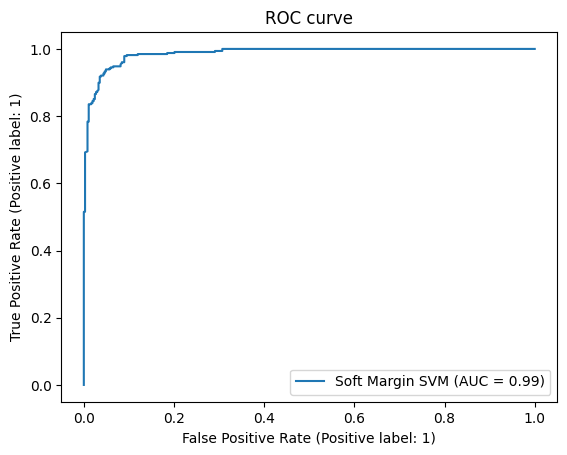

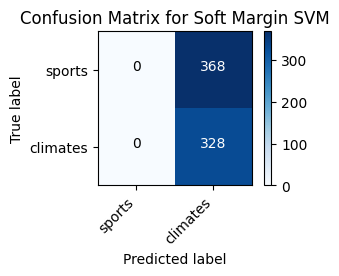

In [ ]:
plot_and_metric('Soft Margin SVMs:', binary_testing_label, predicted_SVM_soft)
plot_roc_curve(clf_SVM_soft, X_test_LSI, binary_testing_label, 'Soft Margin SVM')
plot_confusion_matrix(confusion_matrix(binary_testing_label, predicted_SVM_soft), classes=class_names, title='Confusion Matrix for Soft Margin SVM')


#### SVM y=100000

In [ ]:
# Train a Linear SVM classifier on the LSI training data
clf_SVM_100000 = SVC(kernel='linear', C = 100000, random_state=42)
clf_SVM_100000.fit(X_train_LSI, binary_training_label)

# Predict the labels of the test data
predicted_SVM_100000= clf_SVM_hard.predict(X_test_LSI)
predicted_prob_SVM_100000 = clf_SVM_hard.decision_function(X_test_LSI)

C = 100000:
confusion_matrix:
 [[351  17]
 [ 12 316]]
accuracy: 0.9583333333333334
recall: 0.9634146341463414
precision: 0.948948948948949
f1_score: 0.9561270801815432


<Figure size 300x200 with 0 Axes>

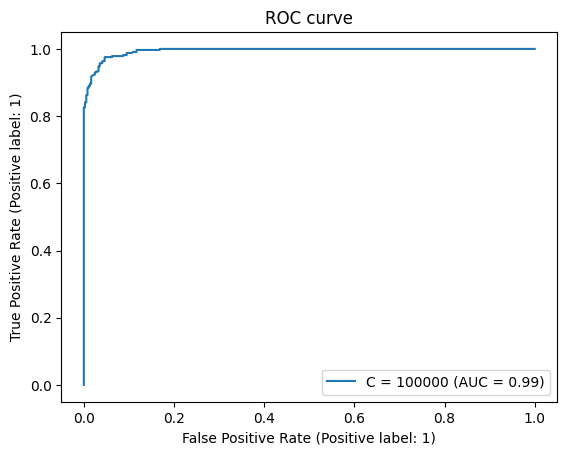

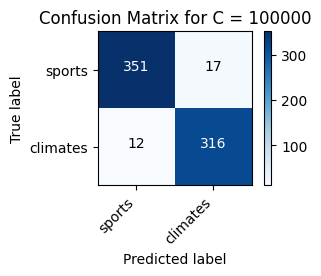

In [ ]:
plot_and_metric('C = 100000:', binary_testing_label, predicted_SVM_100000)
plot_roc_curve(clf_SVM_100000, X_test_LSI, binary_testing_label, 'C = 100000')
plot_confusion_matrix(confusion_matrix(binary_testing_label, predicted_SVM_100000), classes=class_names, title='Confusion Matrix for C = 100000')

#### Cross-Validation to choose y

In [ ]:
gamma = [10**i for i in range(-3,7,1)]
validation_acc = []
for G in gamma:
  clf = SVC(kernel='linear', C=G, random_state=42)
  scores = cross_val_score(clf, X_train_LSI, binary_training_label, cv=5)
  print("Gamma = %0.3f: %0.9f accuracy with a standard deviation of %0.2f" % (G, scores.mean(), scores.std()))
  validation_acc.append(scores.mean())


Gamma = 0.001: 0.502877698 accuracy with a standard deviation of 0.00
Gamma = 0.010: 0.755755396 accuracy with a standard deviation of 0.04
Gamma = 0.100: 0.939568345 accuracy with a standard deviation of 0.01
Gamma = 1.000: 0.950359712 accuracy with a standard deviation of 0.01
Gamma = 10.000: 0.956474820 accuracy with a standard deviation of 0.00
Gamma = 100.000: 0.957553957 accuracy with a standard deviation of 0.00
Gamma = 1000.000: 0.955035971 accuracy with a standard deviation of 0.01
Gamma = 10000.000: 0.954676259 accuracy with a standard deviation of 0.01
Gamma = 100000.000: 0.954316547 accuracy with a standard deviation of 0.01
Gamma = 1000000.000: 0.954676259 accuracy with a standard deviation of 0.01


Text(0.5, 1.0, 'Determining the best gamma value')

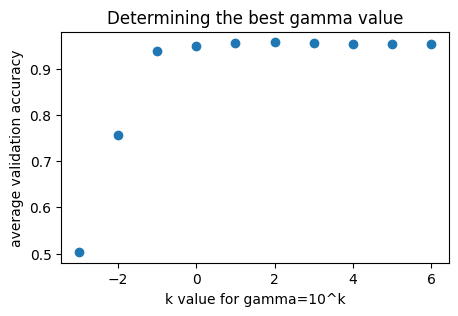

In [ ]:
plt.figure(figsize=(5,3))
plt.scatter(range(-3,7,1),validation_acc)
plt.xlabel('k value for gamma=10^k')
plt.ylabel('average validation accuracy')
plt.title('Determining the best gamma value')

In [ ]:
best_accuracy = np.argmax(validation_acc)
best_gamma = gamma[best_accuracy]
print('Best gamma value: ',best_gamma)

clf_svm_best = SVC(kernel='linear', C=best_gamma, random_state=42)
clf_svm_best.fit(X_train_LSI, binary_training_label)

# Predict the labels of the test data
clf_svm_best_predicted = clf_svm_best.predict(X_test_LSI)
clf_svm_best_predicted_prob = clf_svm_best.decision_function(X_test_LSI)


Best gamma value:  100


Best gamma value:
confusion_matrix:
 [[354  14]
 [ 13 315]]
accuracy: 0.9612068965517241
recall: 0.9603658536585366
precision: 0.9574468085106383
f1_score: 0.9589041095890412


<Figure size 300x200 with 0 Axes>

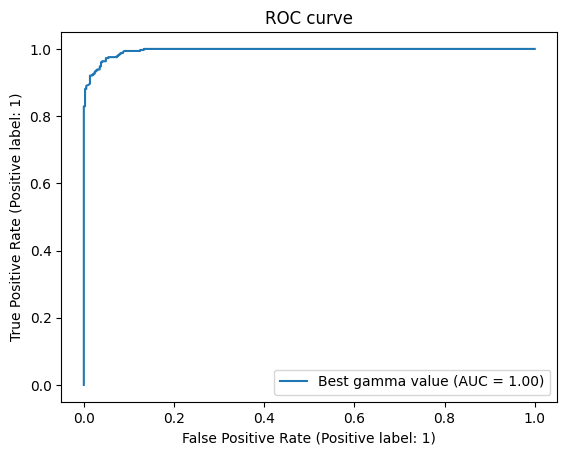

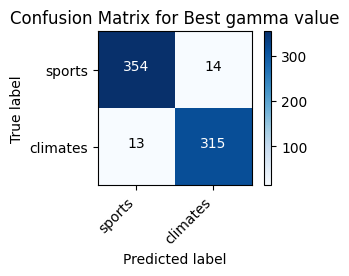

In [ ]:
plot_and_metric('Best gamma value:', binary_testing_label, clf_svm_best_predicted)
plot_roc_curve(clf_svm_best, X_test_LSI, binary_testing_label, 'Best gamma value')
plot_confusion_matrix(confusion_matrix(binary_testing_label, clf_svm_best_predicted), classes=class_names, title='Confusion Matrix for Best gamma value')

### <span style="color:lightpink">Question 5:</span>

**Plot the ROC curve, report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of both SVM classifiers on the testing set. Which one performs better? What about for γ = 100000?**

|                   | Accuracy | Recall  | Precision | F-1 Score |
|-------------------|----------|---------|-----------|-----------|
| Hard Margin       | 0.9583   | 0.9634  | 0.9489    | 0.9561    |
| Soft Margin       | 0.4713   | 1.0000  | 0.4713    | 0.6406    |
| Best (C=100000)   | 0.9583   | 0.9634  | 0.9489    | 0.9561    |


The Hard margin SVM is better. The accuracy of γ = 100000 is the same as the Hard margin SVM.

**What happens for the soft margin SVM? Why is the case? Analyze in terms of the confusion matrix.**

Based on the confusion matrix, the soft margin SVM classifies all samples as label "climate". It underfits the data. Because the soft margin SVM is more sensitive to outliers, and the data is probably not linearly separable, as it  introduces a penalty term that controls the trade-off between increasing the margin size and ensuring that the instances fall on the correct side of the hyperplane.

**Does the ROC curve reflect the performance of the soft-margin SVM? Why?**

Yes. Because the ROC curve is based on the true positive rate and false positive rate, we can see the left upper corner of the ROC curve does not as good as the hard margin SVM, which is not close to the most upper left corner.


**Use cross-validation to choose the best value of γ.**

The best value of γ is 100. The plot and confusion matrix are shown above.

## Logistic Regression

In [ ]:
logistic_regression_with_out_penalty = LogisticRegression(random_state=42, penalty=None, solver='newton-cholesky')
logistic_regression_with_out_penalty.fit(X_train_LSI, binary_training_label)

LogisticRegression(penalty=None, random_state=42, solver='newton-cholesky')

Logistic Regression with no penalty:
confusion_matrix:
 [[353  15]
 [ 14 314]]
accuracy: 0.9583333333333334
recall: 0.9573170731707317
precision: 0.9544072948328267
f1_score: 0.9558599695585996


<Figure size 300x200 with 0 Axes>

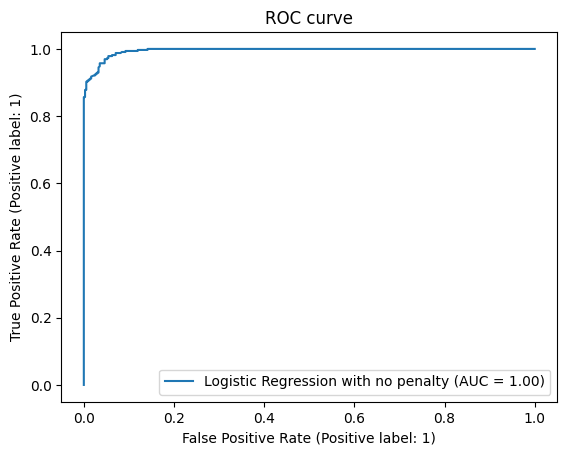

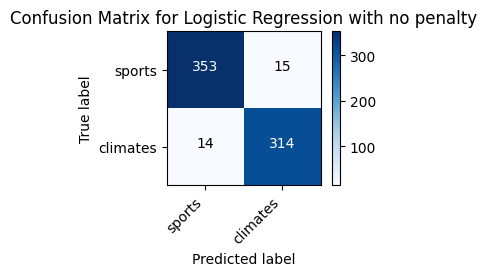

In [ ]:
plot_and_metric('Logistic Regression with no penalty:', binary_testing_label, logistic_regression_with_out_penalty.predict(X_test_LSI))
plot_roc_curve(logistic_regression_with_out_penalty, X_test_LSI, binary_testing_label, 'Logistic Regression with no penalty')
plot_confusion_matrix(confusion_matrix(binary_testing_label, logistic_regression_with_out_penalty.predict(X_test_LSI)), classes=class_names, title='Confusion Matrix for Logistic Regression with no penalty')

In [ ]:
grid_values = {'C': [10**i for i in range(-5,6,1)]}
estimator = LogisticRegression(random_state=42, penalty="l2", solver='newton-cg')
logistic_regression_cv = GridSearchCV(estimator=estimator, param_grid=grid_values, cv=5)
logistic_regression_cv.fit(X_train_LSI, binary_training_label)


GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=42, solver='newton-cg'),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000, 100000]})

In [ ]:
params = logistic_regression_cv.cv_results_["params"]
test_scores = logistic_regression_cv.cv_results_["mean_test_score"]
# format print params and test_scores
for p, s in zip(params, test_scores):
    print(p, s)

print("Best C value for l2:", logistic_regression_cv.best_params_['C'])

{'C': 1e-05} 0.5028776978417266
{'C': 0.0001} 0.5028776978417266
{'C': 0.001} 0.8107913669064748
{'C': 0.01} 0.941726618705036
{'C': 0.1} 0.9435251798561151
{'C': 1} 0.9485611510791367
{'C': 10} 0.9571942446043165
{'C': 100} 0.9582733812949641
{'C': 1000} 0.9575539568345324
{'C': 10000} 0.9568345323741007
{'C': 100000} 0.9568345323741007
Best C value for l2: 100


In [ ]:
estimator = LogisticRegression(random_state=42, penalty="l1", solver='liblinear')
logistic_regression_cv = GridSearchCV(estimator=estimator, param_grid=grid_values, cv=5)
logistic_regression_cv.fit(X_train_LSI, binary_training_label)

GridSearchCV(cv=5,
             estimator=LogisticRegression(penalty='l1', random_state=42,
                                          solver='liblinear'),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000, 100000]})

In [ ]:
params = logistic_regression_cv.cv_results_["params"]
test_scores = logistic_regression_cv.cv_results_["mean_test_score"]
# format print params and test_scores
for p, s in zip(params, test_scores):
    print(p, s)

print("Best C value for l1: ", logistic_regression_cv.best_params_['C'])

{'C': 1e-05} 0.4971223021582734
{'C': 0.0001} 0.4971223021582734
{'C': 0.001} 0.4971223021582734
{'C': 0.01} 0.4971223021582734
{'C': 0.1} 0.9269784172661872
{'C': 1} 0.9510791366906475
{'C': 10} 0.9553956834532373
{'C': 100} 0.9568345323741007
{'C': 1000} 0.9568345323741007
{'C': 10000} 0.9568345323741007
{'C': 100000} 0.9568345323741007
Best C value for l1:  100


In [ ]:
logistic_regression_with_out_penalty_best = LogisticRegression(random_state=42, penalty=None, solver='newton-cholesky', C=100)
logistic_regression_with_out_penalty_best.fit(X_train_LSI, binary_training_label)

logistic_regression_with_l1_penalty = LogisticRegression(random_state=42, penalty='l1', solver='liblinear',C=100)
logistic_regression_with_l1_penalty.fit(X_train_LSI, binary_training_label)

logistic_regression_with_l2_penalty = LogisticRegression(random_state=42, penalty='l2', solver='newton-cg',C=100)
logistic_regression_with_l2_penalty.fit(X_train_LSI, binary_training_label)


LogisticRegression(C=100, random_state=42, solver='newton-cg')

In [ ]:
plot_and_metric('Logistic Regression with no penalty:', binary_testing_label, logistic_regression_with_out_penalty_best.predict(X_test_LSI))
plot_and_metric('Logistic Regression with l1 penalty:', binary_testing_label, logistic_regression_with_l1_penalty.predict(X_test_LSI))
plot_and_metric('Logistic Regression with l2 penalty:', binary_testing_label, logistic_regression_with_l2_penalty.predict(X_test_LSI))


Logistic Regression with no penalty:
confusion_matrix:
 [[353  15]
 [ 14 314]]
accuracy: 0.9583333333333334
recall: 0.9573170731707317
precision: 0.9544072948328267
f1_score: 0.9558599695585996
Logistic Regression with l1 penalty:
confusion_matrix:
 [[353  15]
 [ 14 314]]
accuracy: 0.9583333333333334
recall: 0.9573170731707317
precision: 0.9544072948328267
f1_score: 0.9558599695585996
Logistic Regression with l2 penalty:
confusion_matrix:
 [[354  14]
 [ 14 314]]
accuracy: 0.9597701149425287
recall: 0.9573170731707317
precision: 0.9573170731707317
f1_score: 0.9573170731707317


### <span style="color:lightpink">Question 6:</span>

**– Using 5-fold cross-validation on the dimension-reduced-by-SVD training data, find the optimal regularization strength in the range {10k |−5 ≤ k ≤ 5, k ∈ Z} for logistic regression with L1 regularization and logistic regression with L2 regularization, respectively.**

We using 5-fold cross validation on the dimension-reduced-by-SVD training data. For L1 regularizatiion and L2 regularizatiion, we find the optimal regularization strength is C = 100. When C = 100, for L1, the score is 0.957. For L2, the score is 0.958. (You can find the these values above)


**– Compare the performance (accuracy, precision, recall and F-1 score) of 3 logistic classifiers: w/o regularization, w/ L1 regularization and w/ L2 regularization (with the best parameters you found from the part above), using test data.**
|                               | Accuracy | Recall  | Precision | F-1 Score |
|-------------------------------|----------|---------|-----------|-----------|
| Logistic Regression (No Penalty) | 0.9583   | 0.9573  | 0.9544    | 0.9559    |
| Logistic Regression (L1 Penalty) | 0.9583   | 0.9573  | 0.9544    | 0.9559    |
| Logistic Regression (L2 Penalty) | 0.9598   | 0.9573  | 0.9573    | 0.9573    |


We conclude the performance of 3 logistic classifiers. In the table, we can see that "L2 Penalty" have the highest accuracy, which is 0.9598. "No Penalty" and "L1 Penalty" have the same accuracy, which is 0.9583.

**– How does the regularization parameter affect the test error? How are the learnt coefficients affected? Why might one be interested in each type of regularization?**

Insufficient regularization: If the regularization parameter is too low, the model may overfit the training data, resulting in high variance and high test error. Over-regularization: If the regularization parameter is too high, the model may underfit the training data, resulting in high bias and high test error. Optimal regularization: The right amount of regularization can balance the trade-off between bias and variance, thereby minimizing test error.

For L1 regularization, less important feature coefficients can be reduced to 0, allowing effective feature selection. For L2 regularization, the coefficients will shrink close to 0, but not to 0.

For L1 regularization, this can be chosen when one wants a sparse model, i.e. a model with fewer features. L1 regularization is useful when people have a large number of features but only a few are useful. L2 regularization is a good choice when one wants to include all features but penalize the coefficients of these features to avoid overfitting. When multicollinearity exists in the data, L2 regularization can handle this problem by assigning coefficient weights among related features.

**– Both logistic regression and linear SVM are trying to classify data points using a linear decision boundary. What is the difference between their ways to find this boundary? Why do their performances differ? Is this difference statistically significant?**

There are some differences between them to find boundary. For margins, the logistic regression does not explicitly consider the margin between classes, but SVM tries to maximize it. For data points, in logistic regression, all data points contribute to the fit, whereas in SVM, only the support vectors have an effect on the location of the decision boundary. Also, logistic regression is more of a probabilistic model, whereas SVM is a geometric model. The difference is not statistically significant.

## Naive Bayes Model

Gaussian Naive Bayes:
confusion_matrix:
 [[349  19]
 [ 43 285]]
accuracy: 0.9109195402298851
recall: 0.8689024390243902
precision: 0.9375
f1_score: 0.9018987341772152


<Figure size 300x200 with 0 Axes>

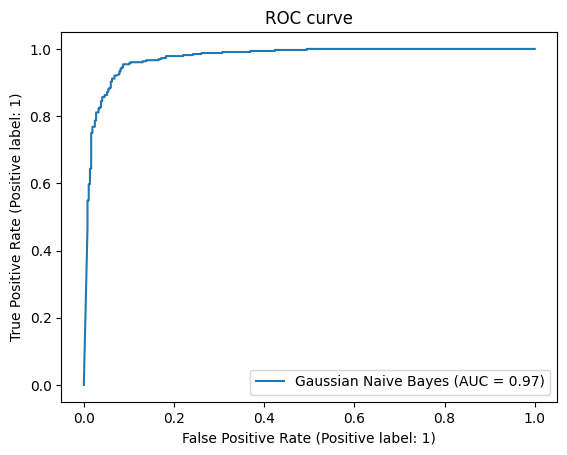

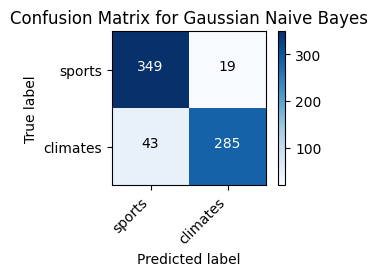

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train_LSI, binary_training_label)

plot_and_metric('Gaussian Naive Bayes:', binary_testing_label, gnb.predict(X_test_LSI))
plot_roc_curve(gnb, X_test_LSI, binary_testing_label, 'Gaussian Naive Bayes')
plot_confusion_matrix(confusion_matrix(binary_testing_label, gnb.predict(X_test_LSI)), classes=class_names, title='Confusion Matrix for Gaussian Naive Bayes')


### <span style="color:lightpink">Question 7:</span>
**- Evaluate and profile a Naive Bayes classifier: Train a GaussianNB classifier; plot the ROC curve and report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of this classifier on the testing set.**

The **ROC curve** is above the question 7.

This table is the **confusion matrix**.
|                  | Predicted Negative | Predicted Positive |
|------------------|--------------------|--------------------|
| Actual Negative  | 349                | 19                 |
| Actual Positive  | 43                 | 285                |

This table is the **accuracy, recall, precision and F-1 score**.
|                | Value           |
|----------------|-----------------|
| Accuracy       | 0.9109          |
| Recall         | 0.8689          |
| Precision      | 0.9375          |
| F1 Score       | 0.9019          |


## Grid Search of Parameters

In [ ]:
vectorizer = CountVectorizer(stop_words='english', min_df=3)
tfidf_transformer = TfidfTransformer()
svd = TruncatedSVD(random_state=42)
clf = SVC(random_state=42)
Pipeline = Pipeline([('vect', vectorizer), ('tfidf', tfidf_transformer), ('dementionality_reduction', svd), ('clf', clf)])

params = {'vect__min_df': [3, 5],
            'dementionality_reduction': [TruncatedSVD(n_components=5, random_state=42),TruncatedSVD(n_components=30, random_state=42),TruncatedSVD(n_components=80, random_state=42),
                                        NMF(n_components=5, random_state=42),NMF(n_components=30, random_state=42),NMF(n_components=80, random_state=42)],
            'clf': [SVC(C=100, random_state=42), LogisticRegression(C=100, random_state=42, penalty='l1', solver='liblinear'),
              LogisticRegression(C=100, random_state=42, penalty='l2', solver='newton-cg'), GaussianNB()]}


In [ ]:
grid_search = GridSearchCV(Pipeline, param_grid=params, cv=5)
grid_search.fit(train['full_text'], binary_training_label)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(min_df=3,
                                                        stop_words='english')),
                                       ('tfidf', TfidfTransformer()),
                                       ('dementionality_reduction',
                                        TruncatedSVD(random_state=42)),
                                       ('clf', SVC(random_state=42))]),
             param_grid={'clf': [SVC(C=100, random_state=42),
                                 LogisticRegression(C=100, penalty='l1',
                                                    random_state=42,
                                                    solver='liblinear'),
                                 LogisticReg...0, random_state=42,
                                                    solver='newton-cg'),
                                 GaussianNB()],
                         'dementionality_reduction': [TruncatedSVD(n_components=5,
                                                                   random_state=42),
                                                      TruncatedSVD(n_components=30,
                                                                   random_state=42),
                                                      TruncatedSVD(n_components=80,
                                                                   random_state=42),
                                                      NMF(n_components=5,
                                                          random_state=42),
                                                      NMF(n_components=30,
                                                          random_state=42),
                                                      NMF(n_components=80,
                                                          random_state=42)],
                         'vect__min_df': [3, 5]})

-----------------------------------
Model {'clf': SVC(C=100, random_state=42), 'dementionality_reduction': TruncatedSVD(n_components=80, random_state=42), 'vect__min_df': 5}
confusion_matrix:
 [[357  11]
 [  8 320]]
accuracy: 0.9727011494252874
recall: 0.975609756097561
precision: 0.9667673716012085
f1_score: 0.9711684370257967


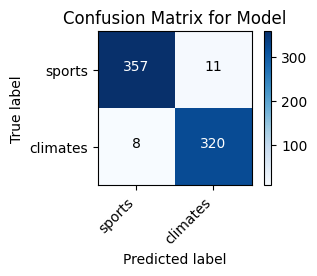

-----------------------------------
Model {'clf': SVC(C=100, random_state=42), 'dementionality_reduction': TruncatedSVD(n_components=80, random_state=42), 'vect__min_df': 3}
confusion_matrix:
 [[357  11]
 [  8 320]]
accuracy: 0.9727011494252874
recall: 0.975609756097561
precision: 0.9667673716012085
f1_score: 0.9711684370257967


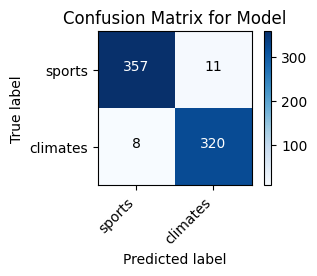

-----------------------------------
Model {'clf': SVC(C=100, random_state=42), 'dementionality_reduction': NMF(n_components=80, random_state=42), 'vect__min_df': 5}
confusion_matrix:
 [[352  16]
 [  5 323]]
accuracy: 0.9698275862068966
recall: 0.9847560975609756
precision: 0.9528023598820059
f1_score: 0.9685157421289355


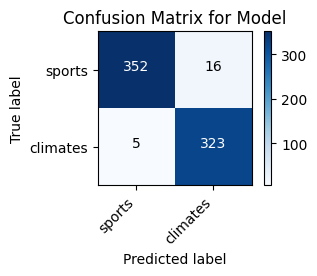

-----------------------------------
Model {'clf': LogisticRegression(C=100, random_state=42, solver='newton-cg'), 'dementionality_reduction': TruncatedSVD(n_components=80, random_state=42), 'vect__min_df': 5}
confusion_matrix:
 [[354  14]
 [ 15 313]]
accuracy: 0.9583333333333334
recall: 0.9542682926829268
precision: 0.9571865443425076
f1_score: 0.9557251908396946


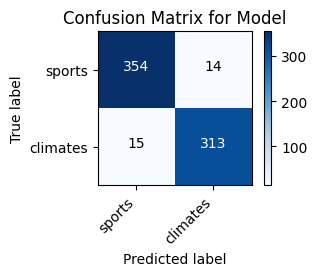

-----------------------------------
Model {'clf': LogisticRegression(C=100, penalty='l1', random_state=42, solver='liblinear'), 'dementionality_reduction': TruncatedSVD(n_components=80, random_state=42), 'vect__min_df': 5}
confusion_matrix:
 [[354  14]
 [ 12 316]]
accuracy: 0.9626436781609196
recall: 0.9634146341463414
precision: 0.9575757575757575
f1_score: 0.9604863221884499


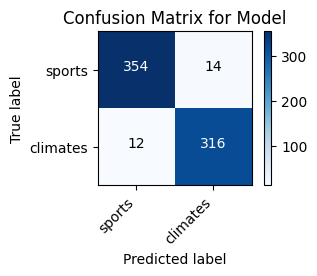

In [ ]:
top_5_model = pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score').head(5)
for model in top_5_model['params']:
    print('-----------------------------------')
    vectorizer = CountVectorizer(stop_words='english', min_df=model['vect__min_df'])
    X_train_counts = count_vect.fit_transform(train['full_text'])
    X_test_counts = count_vect.transform(test['full_text'])
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts).toarray()
    X_test_tfidf = tfidf_transformer.transform(X_test_counts).toarray()
    svd = model['dementionality_reduction']
    X_train = svd.fit_transform(X_train_tfidf)
    X_test = svd.transform(X_test_tfidf)
    clf = model['clf']
    clf.fit(X_train, binary_training_label)
    predicted = clf.predict(X_test)
    plot_and_metric(f'Model {model}', binary_testing_label, predicted)
    plot_confusion_matrix(confusion_matrix(binary_testing_label, predicted), classes=class_names, title=f'Confusion Matrix for Model')


### <span style="color:lightpink">Question 8:</span>
**What are the 5 best combinations? Report their performances on the testing set.**

The 5 best combinations are in the list below.

| Model No. | Classifier                                      | Dimensionality Reduction                      | Vect. Min DF |
|-----------|-------------------------------------------------|-----------------------------------------------|--------------|
| 1         | SVC(C=100, random_state=42)                     | TruncatedSVD(n_components=80, random_state=42) | 5            |
| 2         | SVC(C=100, random_state=42)                     | TruncatedSVD(n_components=80, random_state=42) | 3            |
| 3         | SVC(C=100, random_state=42)                     | NMF(n_components=80, random_state=42)          | 5            |
| 4         | LogisticRegression(C=100, solver='newton-cg')   | TruncatedSVD(n_components=80, random_state=42) | 5            |
| 5         | LogisticRegression(C=100, penalty='l1')         | TruncatedSVD(n_components=80, random_state=42) | 5            |

1. Model:
   - Classifier: `SVC(C=100, random_state=42)`
   - Dimensionality Reduction: `TruncatedSVD(n_components=80, random_state=42)`
   - Vectorizer Minimum DF: `vect__min_df: 5`

2. Model:
   - Classifier: `SVC(C=100, random_state=42)`
   - Dimensionality Reduction: `TruncatedSVD(n_components=80, random_state=42)`
   - Vectorizer Minimum DF: `vect__min_df: 3`

3. Model:
   - Classifier: `SVC(C=100, random_state=42)`
   - Dimensionality Reduction: `NMF(n_components=80, random_state=42)`
   - Vectorizer Minimum DF: `vect__min_df: 5`

4. Model:
   - Classifier: `LogisticRegression(C=100, random_state=42, solver='newton-cg')`
   - Dimensionality Reduction: `TruncatedSVD(n_components=80, random_state=42)`
   - Vectorizer Minimum DF: `vect__min_df: 5`

5. Model:
   - Classifier: `LogisticRegression(C=100, penalty='l1', random_state=42, solver='liblinear')`
   - Dimensionality Reduction: `TruncatedSVD(n_components=80, random_state=42)`
   - Vectorizer Minimum DF: `vect__min_df: 5`


Their performances are above the Question 8.

| Model No. | Accuracy | Recall | Precision | F1 Score |
|-----------|----------|--------|-----------|----------|
| 1         | 0.9727   | 0.9756 | 0.9668    | 0.9712   |
| 2         | 0.9727   | 0.9756 | 0.9668    | 0.9712   |
| 3         | 0.9698   | 0.9848 | 0.9528    | 0.9685   |
| 4         | 0.9583   | 0.9543 | 0.9572    | 0.9557   |
| 5         | 0.9626   | 0.9634 | 0.9576    | 0.9605   |


# Multiclass Classification

In [ ]:
train, test = train_test_split(df[["full_text","leaf_label"]], test_size=0.2, random_state=42)
train.head()

,full_text,leaf_label
2677,'While the four-day Aftershock's economic impa...,earthquake
1204,'CBS Essentials is created independently of th...,football
2955,'Moderate-to-severe drought will likely contin...,drought
2266,"'Colleen Flood, the longtime co-owner of The F...",flood
611,'WASHINGTON TRAFFIC MAY HAVE SAVED HIS LIFE. Y...,baseball


In [ ]:
map_row_to_class = {0:"basketball", 1:"baseball", 2:"tennis", 3:"football", 4:"soccer", 5:"forest fire", 6:"flood",7:"earthquake", 8:"drought", 9:"heatwave"}
map_class_to_row = {"basketball":0, "baseball":1, "tennis":2, "football":3, "soccer":4, "forest fire":5, "flood":6, "earthquake":7, "drought":8, "heatwave":9}

In [ ]:
train['leaf_label'] = train['leaf_label'].map(map_class_to_row)
test['leaf_label'] = test['leaf_label'].map(map_class_to_row)
train_label = train['leaf_label']
test_label = test['leaf_label']

#### Naive Bayes Model with LSI

Naive Bayes Model with LSI:
confusion_matrix:
 [[75  5  5  5  0  0  0  0  0  0]
 [ 2 64  2  1  0  0  2  0  1  3]
 [ 0 11 53  0  3  0  1  0  0  1]
 [ 5  2  0 48  6  0  0  0  0  0]
 [ 0  5  1  1 66  0  0  0  0  0]
 [ 1  5  4  0  2 12  0  1 10 38]
 [ 0  2  0  0  0  1 60  0  1  2]
 [ 0  4  6  0  0  0  0 43  0  1]
 [ 0  3  0  0  1  0  0  0 61  3]
 [ 0  7  4  0  1 22  2  0  5 26]]
accuracy: 0.7298850574712644
recall: 0.7300666735691377
precision: 0.7287653454401968
f1_score: 0.7218838487252027


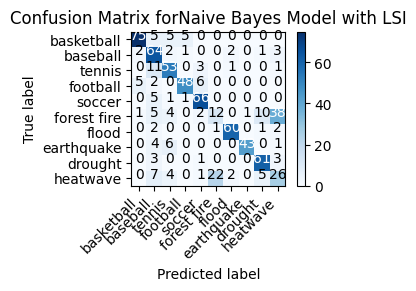

In [ ]:
# Naive Bayes Model with LSI
multi_gnb_lsi = GaussianNB()
multi_gnb_lsi.fit(X_train_LSI, train_label)

lsi_predicted_label = multi_gnb_lsi.predict(X_test_LSI)

plot_and_metric('Naive Bayes Model with LSI:', test_label, lsi_predicted_label, multi_class=True)
plot_confusion_matrix(confusion_matrix(test['leaf_label'], lsi_predicted_label), classes=map_row_to_class.values(), title='Confusion Matrix forNaive Bayes Model with LSI')

#### Naive Bayes Model with NMF

Naive Bayes Model with NMF:
confusion_matrix:
 [[86  0  1  2  1  0  0  0  0  0]
 [ 4 49  8  0  3  0  6  0  2  3]
 [ 3  8 49  0  6  0  3  0  0  0]
 [ 9  1  0 49  2  0  0  0  0  0]
 [ 3  1  2  2 65  0  0  0  0  0]
 [ 1  0  1  0  2 23  8  0 25 13]
 [ 0  0  0  1  0  1 60  0  3  1]
 [ 0  1  4  0  2  0  0 46  1  0]
 [ 0  1  0  0  1  0  2  0 62  2]
 [ 0  0  2  0  3 31  9  0 18  4]]
accuracy: 0.7083333333333334
recall: 0.7060200916366933
precision: 0.6850527618620827
f1_score: 0.6833908312443724


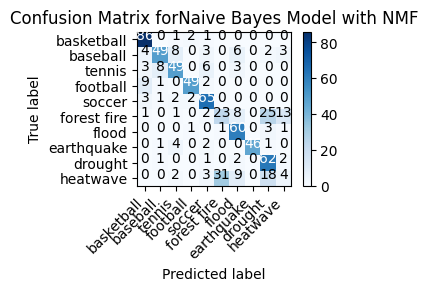

In [ ]:
# Naive Bayes Model with NMF
multi_gnb_nmf = GaussianNB()
multi_gnb_nmf.fit(X_train_NMF, train_label)

nmf_predicted_label = multi_gnb_nmf.predict(X_test_NMF)

plot_and_metric('Naive Bayes Model with NMF:', test_label, nmf_predicted_label, multi_class=True)
plot_confusion_matrix(confusion_matrix(test['leaf_label'], nmf_predicted_label), classes=map_row_to_class.values(), title='Confusion Matrix forNaive Bayes Model with NMF')

#### Naive Bayes Model with TF-IDF

Naive Bayes Model with TF-IDF:
confusion_matrix:
 [[72  3  6  7  1  0  0  0  0  1]
 [ 1 49 10  0  2  3  6  0  0  4]
 [ 0  6 49  0  5  1  2  1  0  5]
 [ 1  6  3 43  5  0  0  0  0  3]
 [ 3  4  6  4 50  0  0  0  0  6]
 [ 0  0  0  0  1 11  0  2  4 55]
 [ 0  2  3  0  0  7 41  1  5  7]
 [ 0  1  1  0  1  1  1 44  3  2]
 [ 2  0  0  0  0 10  0  0 38 18]
 [ 0  0  1  0  0 55  0  1  4  6]]
accuracy: 0.5790229885057471
recall: 0.5788415436257286
precision: 0.6390051133950054
f1_score: 0.6047757596316996


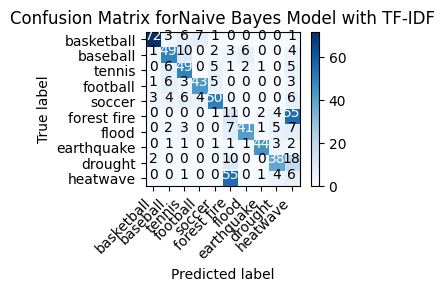

In [ ]:
# Naive Bayes Model with TF-IDF
multi_gnb_tfidf = GaussianNB()
multi_gnb_tfidf.fit(X_train_tfidf, train_label)

tfidf_predicted_label = multi_gnb_tfidf.predict(X_test_tfidf)
plot_and_metric('Naive Bayes Model with TF-IDF:', test_label, tfidf_predicted_label, multi_class=True)
plot_confusion_matrix(confusion_matrix(test['leaf_label'], tfidf_predicted_label), classes=map_row_to_class.values(), title='Confusion Matrix forNaive Bayes Model with TF-IDF')

#### SVM mode One to One with LSI

SVM mode One to One with LSI:
confusion_matrix:
 [[82  3  1  2  0  1  0  0  0  1]
 [ 1 65  2  1  0  4  0  0  0  2]
 [ 0  6 59  0  0  1  1  0  0  2]
 [ 1  1  0 59  0  0  0  0  0  0]
 [ 0  3  3  2 65  0  0  0  0  0]
 [ 0  1  3  0  0 18  0  0  4 47]
 [ 0  2  0  0  0  4 60  0  0  0]
 [ 0  1  3  0  0  0  0 45  0  5]
 [ 0  3  0  0  0  0  0  0 59  6]
 [ 0  3  3  0  0 35  2  0  1 23]]
accuracy: 0.7686781609195402
recall: 0.7690404541007179
precision: 0.7861411235684491
f1_score: 0.7749900896878213


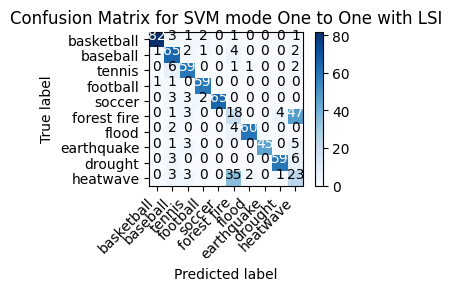

In [ ]:
# SVM mode one to one with LSI
svm_one_to_one_lsi_multi_clf = OneVsOneClassifier(LinearSVC(random_state=42))
svm_one_to_one_lsi_multi_clf.fit(X_train_LSI, train_label)

svm_one_to_one_lsi_predicted_label = svm_one_to_one_lsi_multi_clf.predict(X_test_LSI)

plot_and_metric('SVM mode One to One with LSI:', test_label, svm_one_to_one_lsi_predicted_label, multi_class=True)
plot_confusion_matrix(confusion_matrix(test['leaf_label'], svm_one_to_one_lsi_predicted_label), classes=map_row_to_class.values(), title='Confusion Matrix for SVM mode One to One with LSI')

#### SVM mode One to One with NMF

SVM mode One to One with NMF:
confusion_matrix:
 [[72  1  8  7  0  0  0  0  0  2]
 [ 0 64  3  2  0  0  2  0  0  4]
 [ 0 11 55  0  0  0  1  0  0  2]
 [ 0  2  3 55  0  0  0  0  0  1]
 [ 0  5  4  2 61  0  0  0  0  1]
 [ 0  5  2  0  1 22  0  0  5 38]
 [ 0  2  0  0  0  0 61  0  0  3]
 [ 0  5  3  0  0  0  0 42  0  4]
 [ 0  3  2  0  0  1  0  0 57  5]
 [ 0  6  3  0  0 30  2  0  1 25]]
accuracy: 0.7385057471264368
recall: 0.7402450252736912
precision: 0.7633455834555317
f1_score: 0.7445127483788468


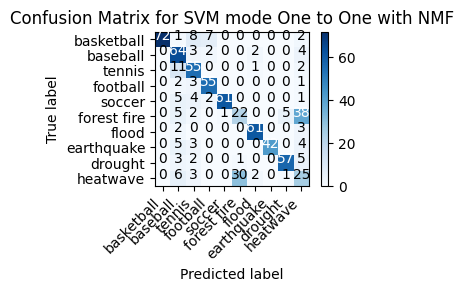

In [ ]:
# SVM mode one to one with NMF
svm_one_to_one_nmf_multi_clf = OneVsOneClassifier(LinearSVC(random_state=42))
svm_one_to_one_nmf_multi_clf.fit(X_train_NMF, train_label)

svm_one_to_one_nmf_predicted_label = svm_one_to_one_nmf_multi_clf.predict(X_test_NMF)

plot_and_metric('SVM mode One to One with NMF:', test_label, svm_one_to_one_nmf_predicted_label, multi_class=True)
plot_confusion_matrix(confusion_matrix(test['leaf_label'], svm_one_to_one_nmf_predicted_label), classes=map_row_to_class.values(), title='Confusion Matrix for SVM mode One to One with NMF')

#### SVM mode One to One with TF-IDF

SVM mode One to One with TF-IDF:
confusion_matrix:
 [[85  1  1  2  0  1  0  0  0  0]
 [ 0 67  1  1  0  3  0  0  0  3]
 [ 0  3 63  0  0  1  1  0  0  1]
 [ 0  1  0 60  0  0  0  0  0  0]
 [ 0  2  1  1 67  0  0  0  0  2]
 [ 0  0  0  0  0 10  0  1  3 59]
 [ 0  2  0  0  0  4 59  0  0  1]
 [ 0  1  0  0  1  2  0 50  0  0]
 [ 0  1  0  0  0  0  0  0 61  6]
 [ 0  0  0  0  0 58  1  0  1  7]]
accuracy: 0.7600574712643678
recall: 0.7610624089298672
precision: 0.7837570614662976
f1_score: 0.7717210910213735


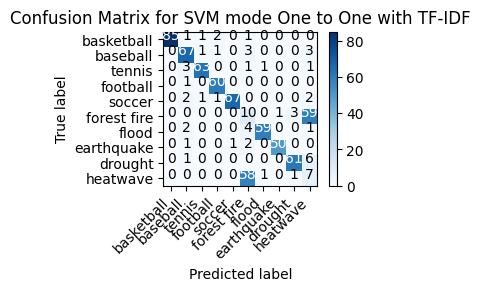

In [ ]:
# SVM mode one to one with TF-IDF
svm_one_to_one_tfidf_multi_clf = OneVsOneClassifier(LinearSVC(random_state=42))
svm_one_to_one_tfidf_multi_clf.fit(X_train_tfidf, train_label)

svm_one_to_one_tfidf_predicted_label = svm_one_to_one_tfidf_multi_clf.predict(X_test_tfidf)

plot_and_metric('SVM mode One to One with TF-IDF:', test_label, svm_one_to_one_tfidf_predicted_label, multi_class=True)
plot_confusion_matrix(confusion_matrix(test['leaf_label'], svm_one_to_one_tfidf_predicted_label), classes=map_row_to_class.values(), title='Confusion Matrix for SVM mode One to One with TF-IDF')

#### SVM mode One to Rest with LSI

SVM mode One to Rest with LSI:
confusion_matrix:
 [[83  3  0  0  0  2  0  0  0  2]
 [ 0 69  1  0  0  2  0  0  2  1]
 [ 0  7 59  0  0  1  1  0  0  1]
 [ 1  0  0 59  1  0  0  0  0  0]
 [ 0  2  1  1 68  0  0  0  0  1]
 [ 0  1  2  0  1 25  0  1  4 39]
 [ 0  2  0  0  0  3 61  0  0  0]
 [ 0  1  1  0  0  2  0 47  0  3]
 [ 0  2  0  0  0  2  0  0 60  4]
 [ 0  4  2  0  0 38  2  0  2 19]]
accuracy: 0.7902298850574713
recall: 0.7899028228825665
precision: 0.8014444807643338
f1_score: 0.7943271134104389


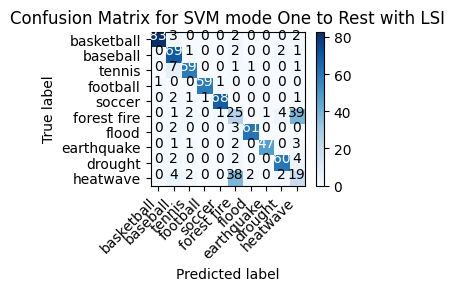

In [ ]:
# SVM mode one to rest with LSI
svm_one_to_rest_lsi_multi_clf = OneVsRestClassifier(LinearSVC(random_state=42,class_weight='balanced'))
svm_one_to_rest_lsi_multi_clf.fit(X_train_LSI, train_label)

svm_one_to_rest_lsi_predicted_label = svm_one_to_rest_lsi_multi_clf.predict(X_test_LSI)

plot_and_metric('SVM mode One to Rest with LSI:', test_label, svm_one_to_rest_lsi_predicted_label, multi_class=True)
plot_confusion_matrix(confusion_matrix(test_label, svm_one_to_rest_lsi_predicted_label), classes=map_row_to_class.values(), title='Confusion Matrix for SVM mode One to Rest with LSI')


#### SVM mode One to Rest with NMF

SVM mode One to Rest with NMF:
confusion_matrix:
 [[78  2  3  5  0  1  0  0  0  1]
 [ 0 65  1  2  0  2  2  0  1  2]
 [ 0 11 53  0  0  0  2  0  0  3]
 [ 1  2  1 57  0  0  0  0  0  0]
 [ 0  3  3  3 63  0  0  0  0  1]
 [ 0  4  1  0  1 27  0  0  5 35]
 [ 0  1  0  0  0  3 61  0  0  1]
 [ 0  3  1  0  0  2  0 44  0  4]
 [ 0  3  0  0  0  2  0  0 58  5]
 [ 0  5  3  0  0 35  3  0  2 19]]
accuracy: 0.7543103448275862
recall: 0.7544332722279348
precision: 0.7700511336524681
f1_score: 0.758757627284337


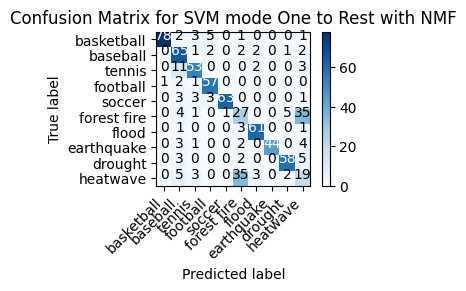

In [ ]:
# SVM mode one to rest with NMF
svm_one_to_rest_nmf_multi_clf = OneVsRestClassifier(LinearSVC(random_state=42,class_weight='balanced'))
svm_one_to_rest_nmf_multi_clf.fit(X_train_NMF, train_label)

svm_one_to_rest_nmf_predicted_label = svm_one_to_rest_nmf_multi_clf.predict(X_test_NMF)

plot_and_metric('SVM mode One to Rest with NMF:', test_label, svm_one_to_rest_nmf_predicted_label, multi_class=True)
plot_confusion_matrix(confusion_matrix(test_label, svm_one_to_rest_nmf_predicted_label), classes=map_row_to_class.values(), title='Confusion Matrix for SVM mode One to Rest with NMF')

#### SVM mode One to Rest with TF-IDF

SVM mode One to Rest with TF-IDF:
confusion_matrix:
 [[86  0  1  2  0  1  0  0  0  0]
 [ 0 67  2  1  0  2  1  0  0  2]
 [ 0  2 62  0  0  1  1  0  1  2]
 [ 0  0  0 61  0  0  0  0  0  0]
 [ 0  0  1  2 68  1  0  0  0  1]
 [ 0  0  0  0  0 12  0  1  3 57]
 [ 0  2  0  0  0  3 60  0  0  1]
 [ 0  0  0  0  1  1  0 51  1  0]
 [ 0  1  0  0  0  1  0  0 61  5]
 [ 0  0  0  0  0 60  1  0  1  5]]
accuracy: 0.7658045977011494
recall: 0.7668551067221883
precision: 0.7838131724012509
f1_score: 0.7748199965667293


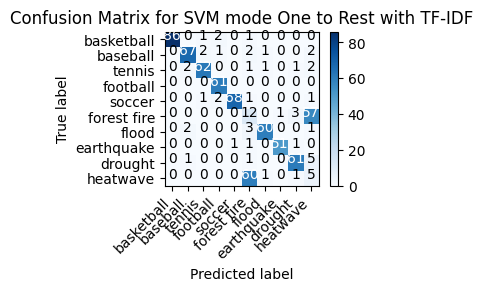

In [ ]:
# SVM mode one to rest with TF-IDF
svm_one_to_rest_tfidf_multi_clf = OneVsRestClassifier(LinearSVC(random_state=42,class_weight='balanced'))
svm_one_to_rest_tfidf_multi_clf.fit(X_train_tfidf, train_label)

svm_one_to_rest_tfidf_predicted_label = svm_one_to_rest_tfidf_multi_clf.predict(X_test_tfidf)

plot_and_metric('SVM mode One to Rest with TF-IDF:', test_label, svm_one_to_rest_tfidf_predicted_label, multi_class=True)
plot_confusion_matrix(confusion_matrix(test_label, svm_one_to_rest_tfidf_predicted_label), classes=map_row_to_class.values(), title='Confusion Matrix for SVM mode One to Rest with TF-IDF')

#### merge "heatwave" into "forest fire"

In [ ]:
train, test = train_test_split(df[["full_text","leaf_label"]], test_size=0.2, random_state=42)
train.head()

,full_text,leaf_label
2677,'While the four-day Aftershock's economic impa...,earthquake
1204,'CBS Essentials is created independently of th...,football
2955,'Moderate-to-severe drought will likely contin...,drought
2266,"'Colleen Flood, the longtime co-owner of The F...",flood
611,'WASHINGTON TRAFFIC MAY HAVE SAVED HIS LIFE. Y...,baseball


In [ ]:
map_row_to_class = {0:"basketball", 1:"baseball", 2:"tennis", 3:"football", 4:"soccer", 5:"forest fire and heatwave", 6:"flood",7:"earthquake", 8:"drought"}
map_class_to_row = {"basketball":0, "baseball":1, "tennis":2, "football":3, "soccer":4, "forest fire":5, "flood":6, "earthquake":7, "drought":8, "heatwave":5}

In [ ]:
train['leaf_label'] = train['leaf_label'].map(map_class_to_row)
test['leaf_label'] = test['leaf_label'].map(map_class_to_row)
train_label = train['leaf_label']
test_label = test['leaf_label']

#### Naive Bayes Model with LSI (Merged)

Naive Bayes Model with LSI:
confusion_matrix:
 [[75  5  5  5  0  0  0  0  0]
 [ 2 63  2  1  0  4  2  0  1]
 [ 0 11 52  0  3  2  1  0  0]
 [ 5  2  0 48  6  0  0  0  0]
 [ 0  5  1  1 66  0  0  0  0]
 [ 1 12  8  0  3 99  2  1 14]
 [ 0  2  0  0  0  3 60  0  1]
 [ 0  4  6  0  0  1  0 43  0]
 [ 0  3  0  0  1  4  0  0 60]]
accuracy: 0.8132183908045977
recall: 0.8236482622653776
precision: 0.8299113385794887
f1_score: 0.8213514762194171


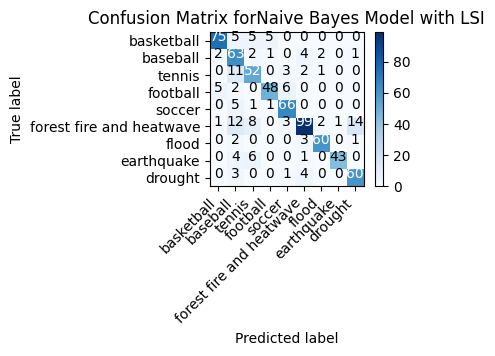

In [ ]:
# Naive Bayes Model with LSI
multi_gnb_lsi = GaussianNB()
multi_gnb_lsi.fit(X_train_LSI, train_label)

lsi_predicted_label = multi_gnb_lsi.predict(X_test_LSI)

plot_and_metric('Naive Bayes Model with LSI:', test_label, lsi_predicted_label, multi_class=True)
plot_confusion_matrix(confusion_matrix(test_label, lsi_predicted_label), classes=map_row_to_class.values(), title='Confusion Matrix forNaive Bayes Model with LSI')

#### Naive Bayes Model with NMF (Merged)

Naive Bayes Model with NMF:
confusion_matrix:
 [[86  0  1  2  1  0  0  0  0]
 [ 4 49  8  0  3  3  6  0  2]
 [ 3  8 49  0  6  0  3  0  0]
 [ 9  1  0 49  2  0  0  0  0]
 [ 3  1  2  2 65  0  0  0  0]
 [ 1  0  4  0  5 70 17  0 43]
 [ 0  0  0  1  0  2 60  0  3]
 [ 0  1  4  0  2  0  0 46  1]
 [ 0  1  0  0  1  2  2  0 62]]
accuracy: 0.7701149425287356
recall: 0.7983812145198816
precision: 0.7951965130848541
f1_score: 0.7806162161929537


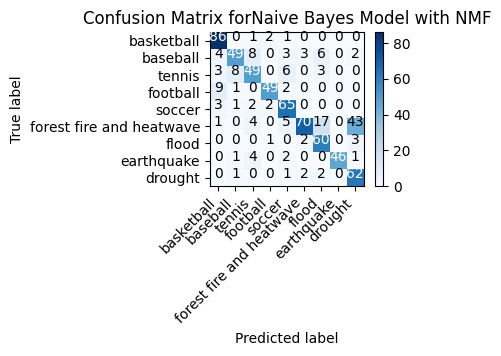

In [ ]:
# Naive Bayes Model with NMF
multi_gnb_nmf = GaussianNB()
multi_gnb_nmf.fit(X_train_NMF, train_label)

nmf_predicted_label = multi_gnb_nmf.predict(X_test_NMF)

plot_and_metric('Naive Bayes Model with NMF:', test_label, nmf_predicted_label, multi_class=True)
plot_confusion_matrix(confusion_matrix(test_label, nmf_predicted_label), classes=map_row_to_class.values(), title='Confusion Matrix forNaive Bayes Model with NMF')

#### Naive Bayes Model with TF-IDF (Merged)

Naive Bayes Model with TF-IDF:
confusion_matrix:
 [[ 72   3   6   7   1   1   0   0   0]
 [  1  49  10   0   2   8   5   0   0]
 [  0   6  49   0   5   6   2   1   0]
 [  1   6   3  43   5   3   0   0   0]
 [  3   4   5   4  50   7   0   0   0]
 [  0   0   1   0   1 127   0   3   8]
 [  0   2   2   0   0  19  37   1   5]
 [  0   1   1   0   1   5   1  43   2]
 [  2   0   0   0   0  28   0   0  38]]
accuracy: 0.7298850574712644
recall: 0.7084662826625272
precision: 0.7623344065848096
f1_score: 0.7270306350670402


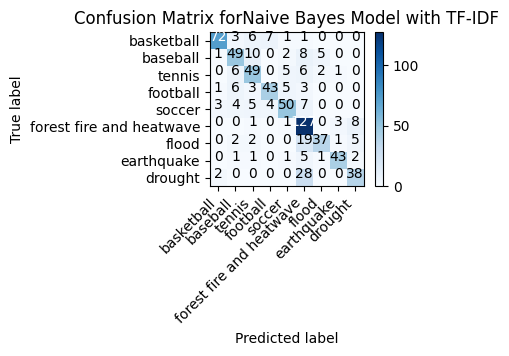

In [ ]:
# Naive Bayes Model with TF-IDF
multi_gnb_tfidf = GaussianNB()
multi_gnb_tfidf.fit(X_train_tfidf, train_label)

tfidf_predicted_label = multi_gnb_tfidf.predict(X_test_tfidf)

plot_and_metric('Naive Bayes Model with TF-IDF:', test_label, tfidf_predicted_label, multi_class=True)
plot_confusion_matrix(confusion_matrix(test_label, tfidf_predicted_label), classes=map_row_to_class.values(), title='Confusion Matrix forNaive Bayes Model with TF-IDF')

#### SVM mode One to One with LSI (Merged)

SVM mode One to One with LSI:
confusion_matrix:
 [[ 82   3   0   0   0   5   0   0   0]
 [  1  60   2   1   0  11   0   0   0]
 [  0   5  50   0   0  13   1   0   0]
 [  1   1   0  59   0   0   0   0   0]
 [  0   3   3   2  65   0   0   0   0]
 [  0   0   0   0   0 134   1   0   5]
 [  0   2   0   0   0   6  58   0   0]
 [  0   0   0   0   0  10   0  44   0]
 [  0   0   0   0   0  11   0   0  57]]
accuracy: 0.875
recall: 0.8647059678657708
precision: 0.9154433069543426
f1_score: 0.884818494267561


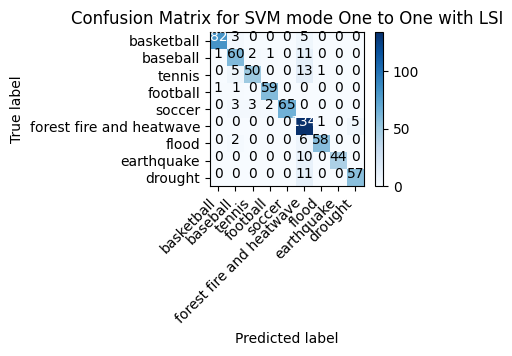

In [ ]:
# SVM mode one to one with LSI
svm_one_to_one_lsi_multi_clf = OneVsOneClassifier(LinearSVC(random_state=42))
svm_one_to_one_lsi_multi_clf.fit(X_train_LSI, train_label)

svm_one_to_one_lsi_predicted_label = svm_one_to_one_lsi_multi_clf.predict(X_test_LSI)

plot_and_metric('SVM mode One to One with LSI:', test_label, svm_one_to_one_lsi_predicted_label, multi_class=True)
plot_confusion_matrix(confusion_matrix(test_label, svm_one_to_one_lsi_predicted_label), classes=map_row_to_class.values(), title='Confusion Matrix for SVM mode One to One with LSI')

#### SVM mode One to One with NMF (Merged)

SVM mode One to One with NMF:
confusion_matrix:
 [[ 69   0   1   7   0  13   0   0   0]
 [  0  50   0   2   0  22   1   0   0]
 [  0   5  36   0   0  28   0   0   0]
 [  0   1   0  49   0  11   0   0   0]
 [  0   2   1   2  55  13   0   0   0]
 [  0   0   0   0   1 134   1   0   4]
 [  0   0   0   0   0  13  53   0   0]
 [  0   0   0   0   0  13   0  41   0]
 [  0   1   0   0   0  16   0   0  51]]
accuracy: 0.7729885057471264
recall: 0.7534675810288191
precision: 0.8882278184791049
f1_score: 0.7981325074628178


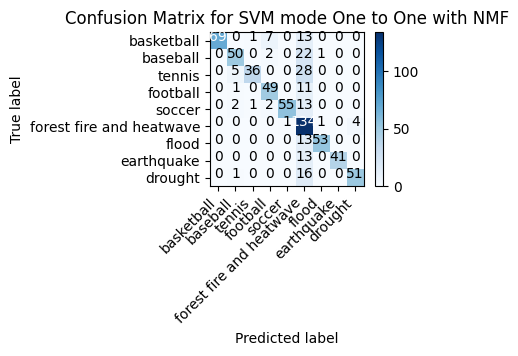

In [ ]:
# SVM mode one to one with NMF
svm_one_to_one_nmf_multi_clf = OneVsOneClassifier(LinearSVC(random_state=42))
svm_one_to_one_nmf_multi_clf.fit(X_train_NMF, train_label)

svm_one_to_one_nmf_predicted_label = svm_one_to_one_nmf_multi_clf.predict(X_test_NMF)

plot_and_metric('SVM mode One to One with NMF:', test_label, svm_one_to_one_nmf_predicted_label, multi_class=True)
plot_confusion_matrix(confusion_matrix(test_label, svm_one_to_one_nmf_predicted_label), classes=map_row_to_class.values(), title='Confusion Matrix for SVM mode One to One with NMF')

#### SVM mode One to One with TF-IDF (Merged)

SVM mode One to One with TF-IDF:
confusion_matrix:
 [[ 85   1   0   2   0   2   0   0   0]
 [  0  66   1   1   0   7   0   0   0]
 [  0   3  61   0   0   4   1   0   0]
 [  0   1   0  60   0   0   0   0   0]
 [  0   0   1   1  66   5   0   0   0]
 [  0   0   0   0   0 134   1   1   4]
 [  0   2   0   0   0   5  59   0   0]
 [  0   1   0   0   1   4   0  48   0]
 [  0   0   0   0   0   8   0   0  60]]
accuracy: 0.9181034482758621
recall: 0.9131714047805216
precision: 0.9399916496427054
f1_score: 0.9246679663293647


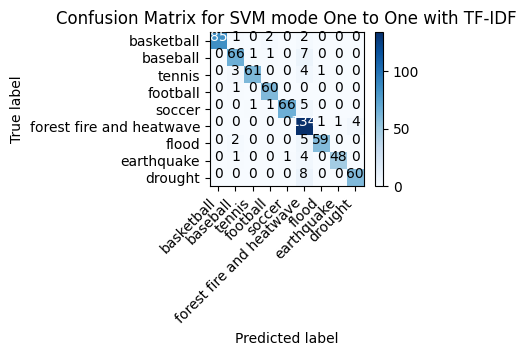

In [ ]:
# SVM mode one to one with TF-IDF
svm_one_to_one_tfidf_multi_clf = OneVsOneClassifier(LinearSVC(random_state=42))
svm_one_to_one_tfidf_multi_clf.fit(X_train_tfidf, train_label)

svm_one_to_one_tfidf_predicted_label = svm_one_to_one_tfidf_multi_clf.predict(X_test_tfidf)

plot_and_metric('SVM mode One to One with TF-IDF:', test_label, svm_one_to_one_tfidf_predicted_label, multi_class=True)
plot_confusion_matrix(confusion_matrix(test_label, svm_one_to_one_tfidf_predicted_label), classes=map_row_to_class.values(), title='Confusion Matrix for SVM mode One to One with TF-IDF')

#### SVM mode One to Rest with LSI (Merged)

SVM mode One to Rest with LSI:
confusion_matrix:
 [[ 84   2   0   0   0   4   0   0   0]
 [  0  62   1   2   1   7   1   0   1]
 [  0   6  51   0   1  10   1   0   0]
 [  2   0   0  59   0   0   0   0   0]
 [  0   0   3   3  66   1   0   0   0]
 [  0   0   0   0   1 131   2   0   6]
 [  0   1   0   0   0   4  61   0   0]
 [  0   0   0   0   0   8   0  46   0]
 [  0   0   0   0   0  10   0   0  58]]
accuracy: 0.8879310344827587
recall: 0.8816892085396614
precision: 0.9149993053788946
f1_score: 0.8950269806429048


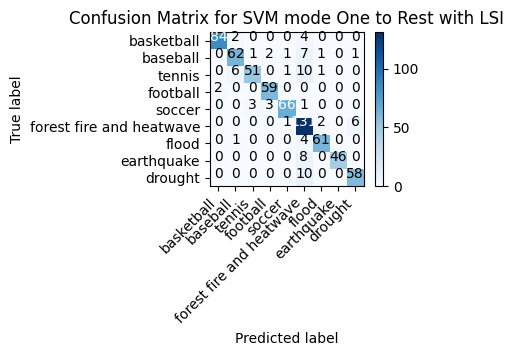

In [ ]:
# SVM mode one to rest with LSI
svm_one_to_rest_lsi_multi_clf = OneVsRestClassifier(LinearSVC(random_state=42))
svm_one_to_rest_lsi_multi_clf.fit(X_train_LSI, train_label)

svm_one_to_rest_lsi_predicted_label = svm_one_to_rest_lsi_multi_clf.predict(X_test_LSI)

plot_and_metric('SVM mode One to Rest with LSI:', test_label, svm_one_to_rest_lsi_predicted_label, multi_class=True)
plot_confusion_matrix(confusion_matrix(test_label, svm_one_to_rest_lsi_predicted_label), classes=map_row_to_class.values(), title='Confusion Matrix for SVM mode One to Rest with LSI')


#### SVM mode One to Rest with NMF (Merged)

SVM mode One to Rest with NMF:
confusion_matrix:
 [[ 78   1   1   7   0   3   0   0   0]
 [  0  56   0   2   0  14   2   0   1]
 [  0   7  41   0   3  16   2   0   0]
 [  0   1   1  57   0   2   0   0   0]
 [  0   2   1   2  65   3   0   0   0]
 [  0   1   0   0   1 129   3   0   6]
 [  0   0   0   0   0   6  60   0   0]
 [  0   0   0   0   0  10   0  44   0]
 [  0   1   0   0   0   9   0   0  58]]
accuracy: 0.8448275862068966
recall: 0.8367387657890275
precision: 0.88704241607878
f1_score: 0.8534145020862639


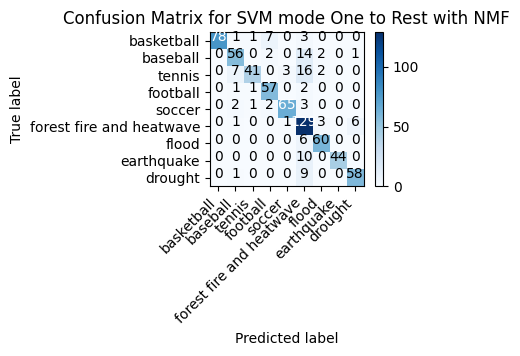

In [ ]:
# SVM mode one to rest with NMF
svm_one_to_rest_nmf_multi_clf = OneVsRestClassifier(LinearSVC(random_state=42))
svm_one_to_rest_nmf_multi_clf.fit(X_train_NMF, train_label)

svm_one_to_rest_nmf_predicted_label = svm_one_to_rest_nmf_multi_clf.predict(X_test_NMF)

plot_and_metric('SVM mode One to Rest with NMF:', test_label, svm_one_to_rest_nmf_predicted_label, multi_class=True)
plot_confusion_matrix(confusion_matrix(test_label, svm_one_to_rest_nmf_predicted_label), classes=map_row_to_class.values(), title='Confusion Matrix for SVM mode One to Rest with NMF')

#### SVM mode One to Rest with TF-IDF (Merged)

SVM mode One to Rest with TF-IDF:
confusion_matrix:
 [[ 87   0   0   2   0   1   0   0   0]
 [  0  67   2   1   0   4   1   0   0]
 [  0   2  63   0   1   2   1   0   0]
 [  0   0   0  61   0   0   0   0   0]
 [  0   0   1   2  68   2   0   0   0]
 [  0   0   0   0   0 134   1   1   4]
 [  0   2   0   0   0   3  61   0   0]
 [  0   0   0   0   2   1   0  51   0]
 [  0   1   0   0   0   7   0   0  60]]
accuracy: 0.9367816091954023
recall: 0.934748110509126
precision: 0.945401557123975
f1_score: 0.9393782662990857


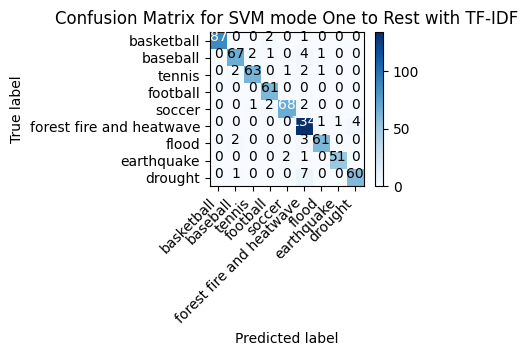

In [ ]:
# SVM mode one to rest with TF-IDF
svm_one_to_rest_tfidf_multi_clf = OneVsRestClassifier(LinearSVC(random_state=42))
svm_one_to_rest_tfidf_multi_clf.fit(X_train_tfidf, train_label)

svm_one_to_rest_tfidf_predicted_label = svm_one_to_rest_tfidf_multi_clf.predict(X_test_tfidf)

plot_and_metric('SVM mode One to Rest with TF-IDF:', test_label, svm_one_to_rest_tfidf_predicted_label, multi_class=True)
plot_confusion_matrix(confusion_matrix(test_label, svm_one_to_rest_tfidf_predicted_label), classes=map_row_to_class.values(), title='Confusion Matrix for SVM mode One to Rest with TF-IDF')

#### SVM mode One to One with LSI (Merged) with balanced data

SVM mode One to One with LSI with balanced class weight:
confusion_matrix:
 [[ 82   3   1   2   0   2   0   0   0]
 [  1  66   2   1   0   5   0   0   0]
 [  0   6  60   0   0   2   1   0   0]
 [  1   1   0  59   0   0   0   0   0]
 [  0   5   1   2  65   0   0   0   0]
 [  0   4   6   0   0 123   2   0   5]
 [  0   2   0   0   0   4  60   0   0]
 [  0   2   3   0   0   2   0  47   0]
 [  0   3   0   0   0   5   0   0  60]]
accuracy: 0.8936781609195402
recall: 0.8954095612633114
precision: 0.9081080360394684
f1_score: 0.899609613602837


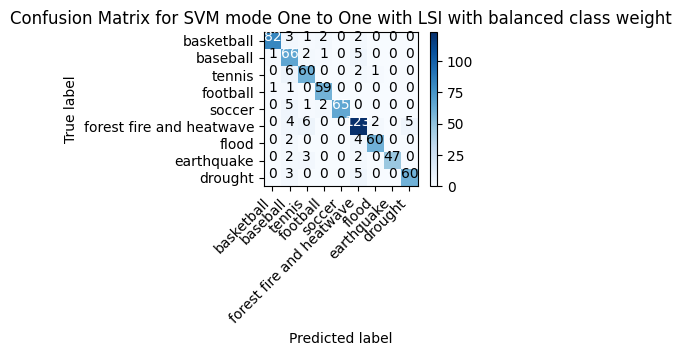

In [ ]:
# SVM mode one to one with LSI with balanced class weight
svm_one_to_one_lsi_multi_clf = OneVsOneClassifier(LinearSVC(random_state=42,class_weight='balanced'))
svm_one_to_one_lsi_multi_clf.fit(X_train_LSI, train_label)

svm_one_to_one_lsi_predicted_label = svm_one_to_one_lsi_multi_clf.predict(X_test_LSI)

plot_and_metric('SVM mode One to One with LSI with balanced class weight:', test_label, svm_one_to_one_lsi_predicted_label, multi_class=True)
plot_confusion_matrix(confusion_matrix(test_label, svm_one_to_one_lsi_predicted_label), classes=map_row_to_class.values(), title='Confusion Matrix for SVM mode One to One with LSI with balanced class weight')


#### SVM mode One to Rest with LSI (Merged) with balanced data

SVM mode One to Rest with LSI with balanced class weight:
confusion_matrix:
 [[ 83   3   0   2   0   1   0   1   0]
 [  0  69   1   0   0   3   0   0   2]
 [  0   7  60   0   0   1   1   0   0]
 [  1   0   0  59   1   0   0   0   0]
 [  0   2   1   1  68   1   0   0   0]
 [  0   3   3   0   1 125   2   1   5]
 [  0   2   0   0   0   3  61   0   0]
 [  0   1   2   0   0   4   0  47   0]
 [  0   2   0   0   0   8   0   0  58]]
accuracy: 0.9051724137931034
recall: 0.9056576130692466
precision: 0.9158578610027163
f1_score: 0.9095141235333093


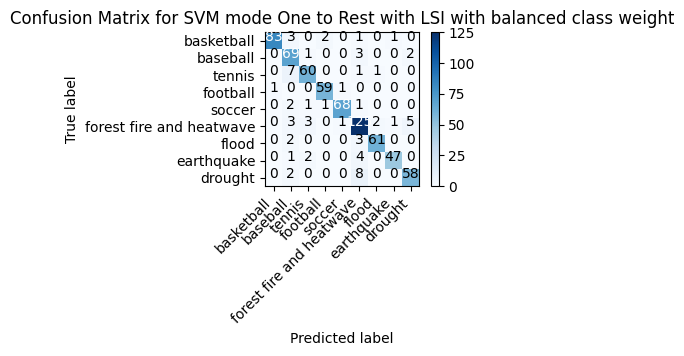

In [ ]:
# SVM mode one to Rest with LSI with balanced class weight
svm_one_to_rest_lsi_multi_clf = OneVsRestClassifier(LinearSVC(random_state=42,class_weight='balanced'))
svm_one_to_rest_lsi_multi_clf.fit(X_train_LSI, train_label)

svm_one_to_rest_lsi_predicted_label = svm_one_to_rest_lsi_multi_clf.predict(X_test_LSI)

plot_and_metric('SVM mode One to Rest with LSI with balanced class weight:', test_label, svm_one_to_rest_lsi_predicted_label, multi_class=True)
plot_confusion_matrix(confusion_matrix(test_label, svm_one_to_rest_lsi_predicted_label), classes=map_row_to_class.values(), title='Confusion Matrix for SVM mode One to Rest with LSI with balanced class weight')

### <span style="color:lightpink">Question 9:</span>

**- How did you resolve the class imbalance issue in the One VS the rest model?**

We add the parameter `class_weight='balanced'` to the `SVC` function. According to the `sklearn` documation, The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).

**- Do you observe any structure in the confusion matrix? Are there distinct visible blocks on the major diagonal? What does this mean?**

Yes, we can see that the confusion matrix's major diagonal is more obvious than others. But for "heatwave" and "forest fire", there exist some misclassified sample between these two categories. Yes, there are distinct visible blocks on the major diagonal. It means that the model is more accurate when the predicted label is the same as the true label.

**- Based on your observation from the previous part, suggest a subset of labels that should be merged into a new larger label and recompute the accuracy and plot the confusion matrix. How did the accuracy change in One VS One and One VS the rest?**
We will merge the label "heatwave" into "forest fire".

The accuracy in One VS One and One VS the rest are increased.

The accuracy in One VS One with LSI is increased from 0.768 to 0.875.

The accuracy in One VS the rest with LSI is increased from 0.790 to 0.887.

The other information is shown above.

**- Does class imbalance impact the performance of the classification once some classes are merged? Provide a resolution for the class imbalance and recompute the accuracy and plot the confusion matrix in One VS One and One VS the rest?.**

Yes, the class imbalance impact the performance of the classification once some classes are merged.

We can see that the accuracy in One VS One and One VS the rest are increased after we merge the label "heatwave" into "forest fire" and balanced the data.

The solution is the same as the previous question 9.1. We add the parameter `class_weight='balanced'` to the `SVC` function.


# Word Embedding

In [ ]:
embeddings_dict = {}
dimension_of_glove = 200
with open(f"glove.6B/glove.6B.{dimension_of_glove}d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [ ]:
vector_woman = embeddings_dict["woman"]
vector_man = embeddings_dict["man"]

# Calculate the Euclidean distance between the vectors
euclidean_distance_1 = np.linalg.norm(vector_woman - vector_man)
print(euclidean_distance_1)

vector_wife = embeddings_dict["wife"]
vector_orange = embeddings_dict["orange"]

# Calculate the Euclidean distance between the vectors
euclidean_distance_2 = np.linalg.norm(vector_wife - vector_orange)
print(euclidean_distance_2)

vector_husband = embeddings_dict["husband"]

# Calculate the Euclidean distance between the vectors
euclidean_distance_3 = np.linalg.norm(vector_wife - vector_husband)
print(euclidean_distance_3)


4.41931
8.328057
3.005187


### <span style="color:lightpink">Question 10:</span>

**(a) Why are GLoVE embeddings trained on the ratio of co-occurrence probabilities rather than the probabilities themselves?**


The first point is to capture subtle relationships. Probability ratios can capture more subtle relationships between words than probabilities themselves. Probability ratios help distinguish such subtle relationships by comparing them with the co-occurrence probabilities of other contextual words. The second point is dealing with rare and frequent words. Direct use of probabilities may cause problems with rare words and very frequent words. Ratios help alleviate these problems by normalizing these probabilities and focusing on the strength of the relationship between words rather than the absolute number of occurrences. The third point is reduce dimensionality. Ratios of co-occurrence probabilities allow GLoVE to effectively capture information in a lower dimensional space.

**(b) In the two sentences: “James is running in the park.” and “James is running for the presidency.”, would GLoVE embeddings return the same vector for the word running in both cases? Why or why not?**

No, GLoVE embeddings will not return the same vector for the word running in both cases. Because GLoVE will understand the word in the context of the sentence. In these two sentences the context is obviously different, so it won't return the same vector.

**(c) The values are:**

$$ \left\lVert \text{GLoVE["woman"]} - \text{GLoVE["man"]} \right\rVert_2 = 4.41931 $$
$$ \left\lVert \text{GLoVE["wife"]} - \text{GLoVE["husband"]} \right\rVert_2 = 3.005187 $$
$$ \left\lVert \text{GLoVE["wife"]} - \text{GLoVE["orange"]} \right\rVert_2 = 8.328057 $$

You can see that the value about wife and orange is the highest. Which means that the meaning of these two words are most unrelated. The value about wife and husband is the lowest. Which means that the meaning of these two words are most related.

**(d) Given a word, would you rather stem or lemmatize the word before mapping it to its GLoVE embedding?**


When mapping a word to its GLoVE embedding, it is often preferred to use lemmatization rather than stemming. The first point is consistency with the training data. GLoVE embeddings are trained on large corpora where the words are not stemmed. Lemmatization is more likely to produce word forms that are actually seen and used during embedding training. The second point is to preserve semantic meaning. Lemmatization takes into account the morphological analysis of words, which is very important. The third point is the representation quality. Lemmatization ensures that the resulting word is a valid token and is more likely to have high-quality pre-trained embeddings.


In [ ]:
train, test = train_test_split(df[["full_text","summary","keywords","leaf_label"]], test_size=0.2, random_state=42)

In [ ]:
# Apply the clean function to the training and testing data
train['full_text'] = train['full_text'].apply(clean)
train['summary'] = train['summary'].apply(clean)

test['full_text'] = test['full_text'].apply(clean)
test['summary'] = test['summary'].apply(clean)


# Apply the lemmatize function to the training and testing data
train['full_text'] = train['full_text'].apply(lemmatize_text)
train['summary'] = train['summary'].apply(lemmatize_text)

test['full_text'] = test['full_text'].apply(lemmatize_text)
test['summary'] = test['summary'].apply(lemmatize_text)




In [ ]:
def get_sentence_embedding(sentence, embeddings_dict, dimension_of_glove):
    # initialize the variables
    sentence_embedding = np.zeros(dimension_of_glove)
    number_of_words = 0
    for word in sentence.split():
        if word in embeddings_dict:
            number_of_words += 1
            sentence_embedding += embeddings_dict[word]
    if number_of_words != 0:
        sentence_embedding /= number_of_words
    return sentence_embedding

train_embeddings = train['full_text'].apply(lambda x: get_sentence_embedding(x, embeddings_dict, dimension_of_glove))
# summary_embeddings = train['summary'].apply(lambda x: get_sentence_embedding(x, embeddings_dict, dimension_of_glove))

# get the actual tranin ebedding by averaging the sentence and summary embedding
# train_embeddings = train_embeddings + summary_embeddings
# train_embeddings /= 2


# train a binary SVM classifier to predict the label of the data point
clf_SVM_hard = SVC(kernel='linear', C = 1000, random_state=42)
clf_SVM_hard.fit(train_embeddings.to_list(), binary_training_label)

# Measure the performance of the classifier on the test data
test_embeddings = test['full_text'].apply(lambda x: get_sentence_embedding(x, embeddings_dict, dimension_of_glove))
predicted_SVM_hard = clf_SVM_hard.predict(test_embeddings.to_list())
plot_and_metric('SVM with GloVe:', binary_testing_label, predicted_SVM_hard)



SVM with GloVe:
confusion_matrix:
 [[343  25]
 [ 13 315]]
accuracy: 0.9454022988505747
recall: 0.9603658536585366
precision: 0.9264705882352942
f1_score: 0.9431137724550899


### <span style="color:lightpink">Question 11:</span>

**- Describe a feature engineering process that uses GLoVE word embeddings to represent eachdocument.**

We use GLoVE word embeddings to represent each document by averaging the word embeddings for the "full_text" of all words in the paragraph. The code is shown above.


In [ ]:
validation_acc = []
dimension_of_glove = [50,100,200,300]
for i in dimension_of_glove:
    embeddings_dict = {}
    with open(f"glove.6B/glove.6B.{i}d.txt", 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
    train_embeddings = train['full_text'].apply(lambda x: get_sentence_embedding(x, embeddings_dict, i))
    # train a binary SVM classifier to predict the label of the data point
    clf_SVM_hard = SVC(kernel='linear', C = 1000, random_state=42)
    clf_SVM_hard.fit(train_embeddings.to_list(), binary_training_label)
    # Measure the performance of the classifier on the test data
    test_embeddings = test['full_text'].apply(lambda x: get_sentence_embedding(x, embeddings_dict, i))
    predicted_SVM_hard = clf_SVM_hard.predict(test_embeddings.to_list())
    validation_acc.append(accuracy_score(binary_testing_label, predicted_SVM_hard))



Text(0.5, 1.0, 'Determining the best demension of glove value')

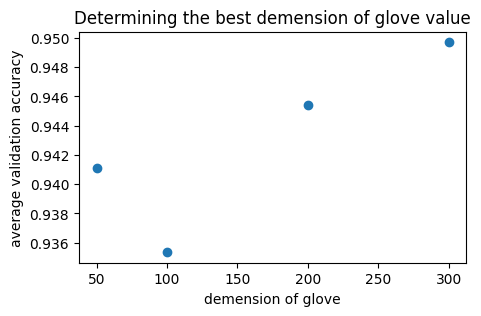

In [ ]:
plt.figure(figsize=(5,3))
plt.scatter(dimension_of_glove ,validation_acc)
plt.xlabel('demension of glove')
plt.ylabel('average validation accuracy')
plt.title('Determining the best demension of glove value')

### <span style="color:lightpink">Question 12:</span>

**- Plot the relationship between the dimension of the pre-trained GLoVE embedding and the resulting accuracy of the model in the classification task. Describe the observed trend.**

The plot is shown above. The trend is that the accuracy is increasing with the increase of the dimension of the pre-trained GLoVE embedding past 100 dimensions.


**- Is this trend expected? Why or why not?**

This trend is expected. After 100 dimensions, when the number of dimensions increase, the number of features will increase. When the dimension is increasing, the vector can capture much more information. So the model is better.

In [ ]:
shape_of_train = np.array(train_embeddings.to_list()).shape

sample = np.random.normal(0, 1, shape_of_train)
sample = sample / np.linalg.norm(sample)
reduce_sample = umap.UMAP(n_components=2, random_state=42).fit(sample)

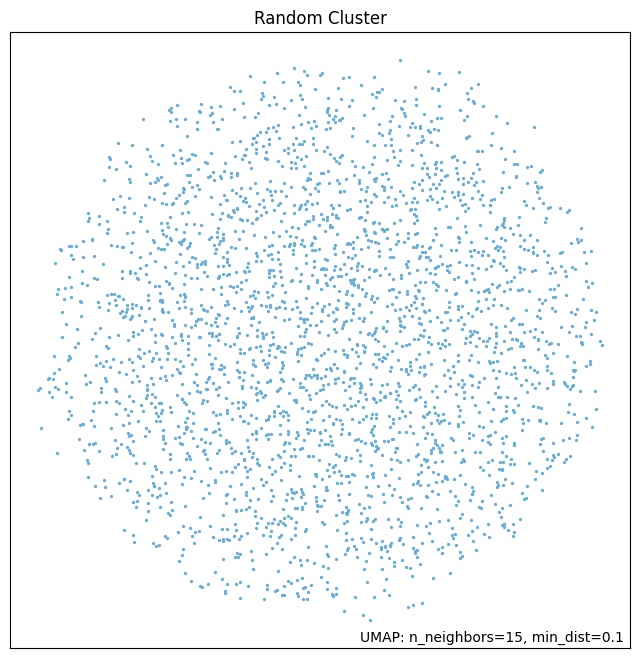

In [ ]:
random = umap.plot.points(reduce_sample)
plt.title('Random Cluster')
plt.show()

In [ ]:
num_to_label = {0:"sports", 1:"climates"}
training_label = [num_to_label[i] for i in binary_training_label]
reduced_dim_embedding = umap.UMAP(n_components=2).fit(np.array(train_embeddings.to_list()))


Text(0.5, 1.0, 'GLoVE cluster')

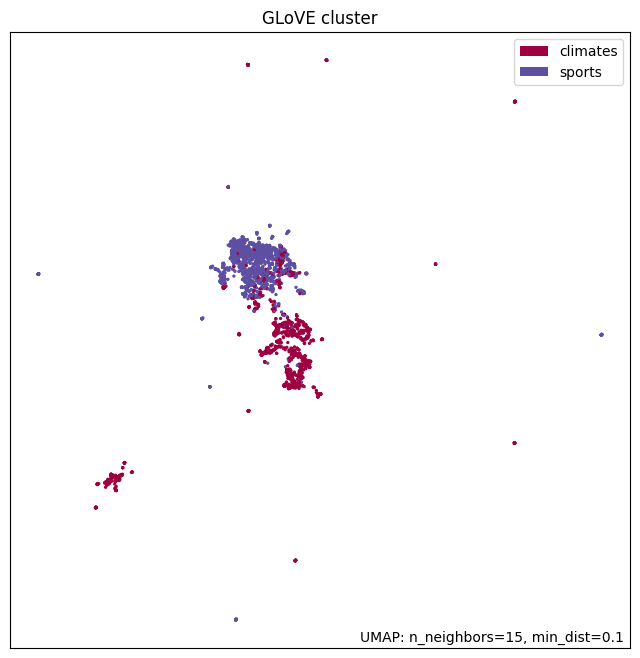

In [ ]:
glove = umap.plot.points(reduced_dim_embedding,labels=np.array(training_label))
plt.title('GLoVE cluster')

### <span style="color:lightpink">Question 13:</span>

**- Are there clusters formed in either or both of the plots?**

No, only the plot of the GLoVE embeddings has clusters.